# Gerrymandering Notebook

Based on GerryChain package.

Aim: determine if the 2011 enacted congressional district in PA was gerrymandered. Compare with the 2018 remedial map enacted by the PA Supreme Court. 

Create a large ensemble of maps to use as a baseline for comparison. 

Sources:

- https://github.com/mggg-states/PA-shapefiles

- https://ballotpedia.org/Redistricting_in_Pennsylvania#cite_note-indy-2

- https://github.com/uwescience/dssg2021-redistricting/blob/main/Georgia/GA_gerrychain.py

In [1]:
# Install gerrychain package
!pip install gerrychain  ## ***** N

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
# Import required packages and libraries

import os
import sys
import re
import tqdm

import csv
import json
import random
import math
import numpy

from functools import partial, reduce
import pandas
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn

import gerrychain

from gerrychain import (
     Election,
     Graph,
     MarkovChain,
     Partition,
     accept,
     constraints,
     updaters
)

import networkx as nx

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, wasted_votes, partisan_bias
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
from gerrychain.accept import always_accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
within_percent_of_ideal_population, UpperBound)

In [2]:
## utility_functions, used to create the graph of nodes

def plot_district_map(df, assignment_dict, title=None, output_path=None, map_colors=None):
    """
    visualize districts corresponding to a given assignment_dict
    mapping index in geopandas dataframe to desired districts per node
    If output_path not provided, will just display image. Otherwise save to location
    
    To customize map colors, input chosen string name of matplotlib's built-in colormaps in map_colors
    If map_colors not provided, cmap will be set to default
    https://matplotlib.org/stable/gallery/color/colormap_reference.html
    https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    df['district_assignment'] = df.index.map(assignment_dict)
    df.plot(column='district_assignment', edgecolor=(1, 1, 1, 0.05), 
            cmap=map_colors, figsize=(12, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    if output_path:
        plt.savefig(output_path)
    else:
        plt.show()


def add_other_population_attribute(graph, total_column_list=["VAP"],
                                   target_population_column_list=["BVAP"],
                                   other_population_name="nBVAP"):
    """
     calculates other population value by finding difference between total
     population and target population. For example, return graph with
     non-BVAP attribute using VAP & BVAP values

    :param graph: networkx graph object
    :param total_column_list: list of all attributes to consider in the 'total population' (e.g. VAP)
    :param target_population_column_list: list of all attributes to consider in the 'target population' (e.g. BVAP)
    :param other_population_name: string - identifer for other population
    :return:
    """

    for node in graph.nodes():
        total_sum = reduce(lambda a, b: a+b, [graph.nodes[node][att]
                                              for att in total_column_list])
        target_sum = reduce(lambda a, b: a+b, [graph.nodes[node][att]
                                               for att in target_population_column_list])
        graph.nodes[node][other_population_name] = total_sum - target_sum

    return graph

def convert_attributes_to_int(graph, attribute_list):
    """
    helper function for casting attributes from string to int
    """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = int(float(graph.nodes[n][attribute]))

    return graph

def convert_attributes_to_float(graph, attribute_list):
    """
     helper function for casting attributes from string to float
     """
    for n in graph.nodes():
        for attribute in attribute_list:
            graph.nodes[n][attribute] = float(graph.nodes[n][attribute])
    return graph


def export_all_metrics_per_chain(chain, output_path,
                                 buffer_length=2000,
                                 include_election=True,
                                 exclude_metrics=['cut_edges', 'boundary_nodes',
                                                  'cut_edges_by_part',
                                                  'area', 'perimeter',
                                                  'interior_boundaries', 'exterior_boundaries'
                                                  ]
                                 ):

    """
    save all metrics for every k steps (k=buffer length) of chain in separate csv file
    Additionally, saves partition assignment at kth step of chain as json

    :param chain: GerryChain chain generator object
    :param output_path: folder to save results in (separate dir per chain)
    :param buffer_length: frequency at which data is written to file
    :param include_election: boolean - specifies whether election related metrics should be saved
    :param exclude_metrics: list - metrics to exclude from output files. All metrics not at district level
                            should be excluded.
    :return:
    """

    os.makedirs(output_path, exist_ok=True)

    all_res = []
    election_res = []
    for i, part in enumerate(chain):
        results = export_all_metrics_per_partition(part, include_election, exclude_metrics)
        all_res.append(results[0].values)

        if include_election:
            election_res.append(results[1].values)

        # save results every i = buffer_length steps
        if (i+1) % buffer_length == 0:
            print(i+1)

            # save non-election related metric results
            for n, metric_name in enumerate(results[0].columns):
                with open(os.path.join(output_path, f"{metric_name}_{str(i+1)}.csv"), 'w') as f:
                    writer = csv.writer(f, lineterminator="\n")
                    writer.writerows(np.array(all_res)[:, :, n])

            all_res = []

            if include_election:
                # save election related metric results
                for n, metric_name in enumerate(results[1].columns):
                    if metric_name == 'percent': #different format - save per election in sep file
                        for row, election_name in enumerate(results[1].index):
                            with open(os.path.join(output_path, f"{election_name}_{metric_name}_{str(i+1)}.csv"), 'w') as f:
                                writer = csv.writer(f, lineterminator='\n')
                                writer.writerows(np.array(election_res)[:, row, n])
                    else: # all other election metrics saved in single file
                        with open(os.path.join(output_path, f"{metric_name}_{str(i+1)}.csv"), 'w') as f:
                            writer = csv.writer(f, lineterminator='\n')
                            writer.writerows(np.array(election_res)[:, :, n])

                election_res = []

            # save assignment for every i steps
            with open(os.path.join(output_path, f'assignment_{str(i+1)}.json'), "w") as f:
                json.dump(dict(part.assignment), f)




def export_all_metrics_per_partition(partition, include_election=True,
                                     exclude_metrics=['cut_edges']):
    """
    returns tuple of dataframes with common metrics calculated at district level
    (split by nonelection & election related)

    :param partition:
    :param include_election: boolean
    :param exclude_metrics: metrics tracked in updater to exclude from export
    :return: returns tuple of dataframe - (nonelection related metrics, election related metrics)
    """
    metric_results = {}
    for name, func in partition.updaters.items():
        if type(func) == Election or name in exclude_metrics:
            continue
        metric_results[name] = partition[name]

    metric_results = pd.DataFrame.from_dict(metric_results)

    if include_election:
        election_results=export_election_metrics_per_partition(partition)
        return (metric_results, election_results)

    return (metric_results,)


def export_election_metrics_per_partition(partition):
    """
    returns dataframe with following metrics for all elections tracked in updater
    using the given partition

    * percent won by first party
    * mean_median score
    * efficiency gap
    * seats won

    :param partition:
    :return: pd dataframe election_results
    """
    elections_info = {}

    # identify elections related updaters being tracked per partition
    for name, func in partition.updaters.items():
        if type(func) == Election:
            elections_info[name] = func.parties

    election_results = {name: {} for name in elections_info.keys()}

    # store stats for each election
    for election_name, parties in elections_info.items():
        election_results[election_name]['percent'] = partition[
            election_name].percents(parties[0])
        election_results[election_name]['efficiency_gap'] = efficiency_gap(
            partition[election_name])
        election_results[election_name]['mean_median'] = mean_median(
            partition[election_name])
        election_results[election_name]['wins'] = partition[
            election_name].wins(parties[0])

    return pd.DataFrame.from_dict(election_results, orient='index')

In [3]:
# Create graph and df objects from data ***** N
graph = Graph.from_file("/work/data/PA/PA.shp") # Must be adapted for each person's directory
df = gpd.read_file("/work/data/PA/PA.shp")      # Must be adapted for each person's directory




/root/venv/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/root/venv/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)


In [4]:

# Data: each row is a VTD, each column is demographic/electoral information
# Glossary of what each field means: https://github.com/mggg-states/PA-shapefiles

# Over 9000 VTDs


df

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,...,TS,CD_2011,SEND,HDIST,538DEM,538GOP,538CMPCT,GOV14D,GOV14R,geometry
0,42,085,960,42085960,A,SHENANGO TWP VTD WEST,SHENANGO TWP VTD WEST,00,G5240,N,...,3,3,50,7,03,03,03,290.000,242.000,"POLYGON ((37033.427 4574062.719, 37048.711 457..."
1,42,039,40,4203940,A,BLOOMING VALLEY Voting District,BLOOMING VALLEY Voting District,00,G5240,N,...,5,3,50,6,03,03,03,45.000,97.000,"POLYGON ((78941.652 4627060.081, 79147.562 462..."
2,42,039,10,4203910,A,ATHENS TWP Voting District,ATHENS TWP Voting District,00,G5240,N,...,5,3,50,65,03,03,03,48.000,156.000,"POLYGON ((91890.036 4636341.145, 91931.180 463..."
3,42,039,20,4203920,A,BEAVER TWP Voting District,BEAVER TWP Voting District,00,G5240,N,...,3,3,50,17,03,03,03,66.000,102.000,"POLYGON ((41746.849 4647823.741, 42071.856 464..."
4,42,039,30,4203930,A,BLOOMFIELD TWP Voting District,BLOOMFIELD TWP Voting District,00,G5240,N,...,5,3,50,65,03,03,03,226.000,231.000,"POLYGON ((92362.943 4644867.586, 92364.853 464..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9250,42,001,100,42001100,A,CONEWAGO TWP VTD 02,CONEWAGO TWP VTD 02,00,G5240,N,...,4,4,33,91,09,04,04,437.512,675.790,"POLYGON ((323871.047 4407084.481, 323883.195 4..."
9251,42,001,480,42001480,A,UNION TWP,UNION TWP Voting District,V2,G5240,N,...,4,4,33,91,09,04,04,247.000,589.000,"POLYGON ((320167.759 4404941.193, 320226.612 4..."
9252,42,001,260,42001260,A,HAMILTON TWP,HAMILTON TWP Voting District,V2,G5240,N,...,4,4,33,193,09,04,04,311.000,490.000,"POLYGON ((322636.281 4417936.773, 322698.260 4..."
9253,42,001,10,4200110,A,ABBOTTSTOWN,ABBOTTSTOWN Voting District,V2,G5240,N,...,4,4,33,193,09,04,04,0.000,124.000,"POLYGON ((329306.063 4417026.449, 329329.891 4..."


In [5]:
#--Set some parameters based on PA
state_abbr="PA"
housen="CON"
num_districts=18
pop_col="TOTPOP"
#num_elections=4

#Make an output directory to put files in
newdir = "./Outputs/"+state_abbr+housen+"_Precincts/"
os.makedirs(newdir, exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Create Folder")

#--Generic updaters
# Population updater, for computing how close to equality the district
# populations are. "TOTPOP" is the population column from our shapefile.
updater = {
    "population": gerrychain.updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges
             }

In [6]:
#--Set some parameters based on analysis
#T16PRESD: Number of votes for 2016 Democratic Presidential candidate
#T16PRESR: Number of votes for 2016 Republican presidential candidate
#PRES12D: Number of votes for 2012 Democratic presidential candidate
#PRES12R: Number of votes for 2012 Republican presidential candidate

#T16SEND: Number of votes for 2016 Democratic senate candidate
#T16SENR: Number of votes for 2016 Republican senate candidate
#USS12D: Number of votes for 2012 Democratic senate candidate
#USS12R: Number of votes for 2012 Republican senate candidate

#VAP - Total voting age population
#HVAP - Hispanic voting age population
#WVAP - White, non-hispanic, voting age population
#BVAP - Black, non-hispanic, voting age population
#CD - US congressional district
 
election_names=[
    "PRES16",
    "PRES12",
    "BVAP",
    "HVAP",
    "WVAP",
    "BHVAP"]

num_elections = len(election_names)

election_columns=[
    ["T16PRESR", "T16PRESD"],
    ["PRES12R", "PRES12D"],
    ["BVAP", "nBVAP"],
    ["HVAP", "nHVAP"],
    ["WVAP", "nWVAP"],
    ["BHVAP", "nBHVAP"]
    ]

In [7]:
#--Setup election updaters
# Election updaters, for computing election results using the vote totals
# from our shapefile.
elections = [
    Election(
        election_names[i], #Name of election
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
        )
        for i in range(num_elections)
] 

election_updaters = {election.name: election for election in elections} 

updater.update(election_updaters)

#Coerce tabular data to correct type
totpop = 0 
for n in graph.nodes():
    totpop+= graph.nodes[n]["TOTPOP"]#The loop is going over all the precincts then adding the populations
    graph.nodes[n]["TOTPOP"] = int(graph.nodes[n]["TOTPOP"])
    graph.nodes[n]["VAP"] = int(graph.nodes[n]["VAP"])
    graph.nodes[n]["BVAP"] = int(graph.nodes[n]["BVAP"])
    graph.nodes[n]["HVAP"] = int(graph.nodes[n]["HVAP"])
    graph.nodes[n]["WVAP"] = int(graph.nodes[n]["WVAP"])
    graph.nodes[n]["CD_2011"] = int(graph.nodes[n]["CD_2011"])
    graph.nodes[n]["T16PRESR"] = int(graph.nodes[n]["T16PRESR"])
    graph.nodes[n]["T16PRESD"] = int(graph.nodes[n]["T16PRESD"])
    graph.nodes[n]["PRES12R"] = int(graph.nodes[n]["PRES12R"])
    graph.nodes[n]["PRES12D"] = int(graph.nodes[n]["PRES12D"])
    
    #Generating populations
    graph.nodes[n]["nBVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["BVAP"]
    graph.nodes[n]["nHVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["HVAP"]
    graph.nodes[n]["nWVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["WVAP"]
    graph.nodes[n]["BHVAP"] = graph.nodes[n]["BVAP"] + graph.nodes[n]["HVAP"]
    graph.nodes[n]["nBHVAP"] = graph.nodes[n]["VAP"] - graph.nodes[n]["BHVAP"]
    

In [8]:
test_elections = [
    Election("SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}),
    Election("SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}),
    Election("SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"})
]

In [9]:
# Election objects from GerryChain:
# https://github.com/mggg/GerryChain/blob/main/gerrychain/updaters/election.py
type(test_elections[0])

gerrychain.updaters.election.Election

Initial partition to be used in the chain:


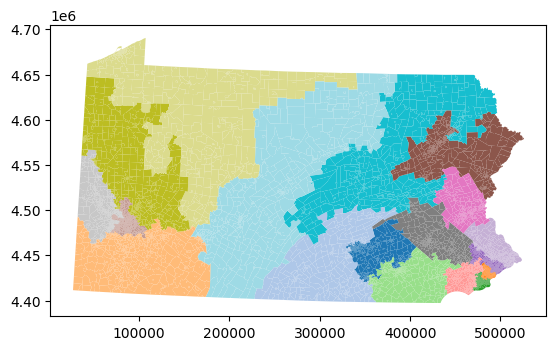

In [15]:
# One alternative: start the chain from a randomly generated tree partition (that satisfies constraints)
# (too expensive to do it 1000s of times) ***** Nico
# https://github.com/mggg-states/PA-shapefiles
# "We suggest using the function recursive_tree_part to create a seed plan as a starting point. If it is important to use one of the plans provided as a starting point for chain, adding edges on your dual graph between nodes (7648,7635) and (1247,1160) should fix connectivity problems for CD_2011 and GOV."

#--Create, Plot, and save seed plan           
cddict = recursive_tree_part(graph,
                                range(num_districts),
                                totpop/num_districts,
                                "TOTPOP",
                                .01, #1% population balance
                                1)
df['initial'] = df.index.map(cddict)


# Build initial Partition
initial_partition = Partition(graph,
                              cddict,
                              updater)



with open(newdir+"init.json", 'w') as jf1:
         json.dump(cddict, jf1) 


df.plot(column="initial", cmap="tab20") #cmap stand for color map
plt.savefig(newdir+"initial.png")
print("Initial partition to be used in the chain:")
plt.show()

In [16]:
#Initialize Proposal (ReCom) ***** N
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by discarding unbalanced partitions early on.

ideal_population = sum(initial_partition["population"].values())/ len(initial_partition)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)    

In [17]:
#Create Constraints (compactness) ***** K
#To keep districts about as compact as the original plan, 
#we bound the number of cut edges at 2 times the number 
#of cut edges in the initial plan.
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"]) 
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.01) 

In [19]:
## Combining county splits and VRA into a single accept function ***** K

# VRA implementation with hard thresholds: there must be at least one 
# district with 54% BVAP, and another with at least 27% BVAP
# This corresponds to the VRA interpretation that new redistrictings should not reduce the
# number of districts where minority groups have ability to choose representatives
first_bvap_thresh = .54
second_bvap_thresh = .27

def county_VRA_accept(partition):
    df['prev'] = df.index.map(partition.parent.assignment.to_dict())
    df['current'] = df.index.map(partition.assignment.to_dict())

    max_split_prev = max(df.groupby('COUNTYFP10')['prev'].nunique())
    max_split_curr = max(df.groupby('COUNTYFP10')['current'].nunique())

    bvap_percs = sorted(partition["BVAP"].percents("First"))
    first_bvap_part = bvap_percs[-1]
    second_bvap_part = bvap_percs[-2]

    VRA_condition = (abs(first_bvap_thresh - first_bvap_part) < 10) and (abs(second_bvap_thresh - second_bvap_part) < 10)

    if not VRA_condition:
        return False

    if max_split_curr <= max_split_prev: # accept all plans that have fewer county splits than parent plan
        return True
    
    elif random.random() < .25: # randomly accept plans that have more county splits with 25% probability
        return True
    else:
        return False


In [15]:
#Create Markov Chains  ***** K
recom_chain = MarkovChain(
    proposal=proposal, # using recom
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound 
    ],    
    accept= county_VRA_accept, 
    initial_state=initial_partition,
    total_steps= 10000
)

In [16]:
recom_chain

<MarkovChain [10000 steps]>

In [17]:
# Run the chain, putting the sorted Democratic vote percentages
# into a pandas DataFrame for analysis and plotting. *****
# This will take a few hours. 

data = pandas.DataFrame(
    sorted(partition["PRES12"].percents("Second"))
    for partition in recom_chain.with_progress_bar()  
) 



/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10000/10000 [1:58:32<00:00,  1.41it/s]


In [38]:
type(data)

pandas.core.frame.DataFrame

In [19]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.353209,0.378716,0.387124,0.401863,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.548504,0.620620,0.632087,0.816238,0.920245
1,0.353209,0.378716,0.387124,0.401863,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.548504,0.620620,0.632087,0.819648,0.914837
2,0.353209,0.384270,0.387124,0.396429,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.548504,0.620620,0.632087,0.819648,0.914837
3,0.353209,0.384270,0.387124,0.396429,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.603441,0.620620,0.632087,0.756981,0.914837
4,0.353209,0.363842,0.384270,0.396429,0.425378,0.438950,0.446205,0.477353,0.489342,0.489575,0.506034,0.527815,0.540674,0.603441,0.620620,0.632087,0.756981,0.914837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.348182,0.357178,0.391472,0.415283,0.427130,0.448622,0.450731,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.617054,0.720280,0.728222,0.910294
9996,0.349955,0.357178,0.391472,0.415283,0.427130,0.448622,0.450299,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.617054,0.720280,0.728222,0.910294
9997,0.349955,0.357178,0.391472,0.415283,0.420801,0.448622,0.450299,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.624254,0.720280,0.728222,0.910294
9998,0.349955,0.372039,0.377964,0.415283,0.420801,0.448622,0.450299,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.624254,0.720280,0.728222,0.910294


In [20]:
# Save data to a csv file 
data.to_csv('chain_outcomes_10k_pres2012.csv')

In [10]:
data = pandas.read_csv('chain_outcomes_10k_pres2012.csv')
data = data.iloc[: , 1:]

In [40]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.353209,0.378716,0.387124,0.401863,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.548504,0.620620,0.632087,0.816238,0.920245
1,0.353209,0.378716,0.387124,0.401863,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.548504,0.620620,0.632087,0.819648,0.914837
2,0.353209,0.384270,0.387124,0.396429,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.548504,0.620620,0.632087,0.819648,0.914837
3,0.353209,0.384270,0.387124,0.396429,0.425378,0.438950,0.446205,0.457785,0.489342,0.489575,0.506034,0.527815,0.540674,0.603441,0.620620,0.632087,0.756981,0.914837
4,0.353209,0.363842,0.384270,0.396429,0.425378,0.438950,0.446205,0.477353,0.489342,0.489575,0.506034,0.527815,0.540674,0.603441,0.620620,0.632087,0.756981,0.914837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.348182,0.357178,0.391472,0.415283,0.427130,0.448622,0.450731,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.617054,0.720280,0.728222,0.910294
9996,0.349955,0.357178,0.391472,0.415283,0.427130,0.448622,0.450299,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.617054,0.720280,0.728222,0.910294
9997,0.349955,0.357178,0.391472,0.415283,0.420801,0.448622,0.450299,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.624254,0.720280,0.728222,0.910294
9998,0.349955,0.372039,0.377964,0.415283,0.420801,0.448622,0.450299,0.461636,0.463685,0.482267,0.516992,0.530782,0.555126,0.563681,0.624254,0.720280,0.728222,0.910294


In [20]:
# Plot in comparison to ENACTED 2011 and REMEDIAL 2018 outcomes
# "dummy" chain to access the Remedial partition

 
initial_partition_remedial = gerrychain.GeographicPartition(graph,
                              "REMEDIAL",
                              updater)

ideal_population_remedial = sum(initial_partition_remedial["population"].values())/ len(initial_partition_remedial)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal_remedial = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population_remedial, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)  

recom_chain_remedial = MarkovChain(
    proposal=proposal_remedial,
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound 
        #VRA_cutoffs
    ],    
    accept= county_VRA_accept, 
    initial_state=initial_partition_remedial,
    total_steps= 2
)
data_remedial = pandas.DataFrame(
    sorted(partition["PRES12"].percents("Second"))
    for partition in recom_chain_remedial.with_progress_bar()
)

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


In [21]:
# "dummy" chain to access the 2011 enacted partition

initial_partition_enacted2011 = gerrychain.GeographicPartition(graph,
                              "CD_2011",
                              updater)

ideal_population_enacted2011 = sum(initial_partition_enacted2011["population"].values())/ len(initial_partition_enacted2011)
# We use functools.partial to bind the extra parameters 
# (pop_col, pop_target, epsilon, node_repeats) of the recom proposal.
proposal_enacted2011 = partial(
    recom, 
    pop_col="TOTPOP", 
    pop_target=ideal_population_enacted2011, 
    epsilon=0.01, #1% deviations population balance
    node_repeats=1
    #method = bipartition_tree_random
)  

recom_chain_enacted2011 = MarkovChain(
    proposal=proposal_enacted2011,
    constraints=[
        pop_constraint, #changed from 0.01
        compactness_bound 
        #VRA_cutoffs
    ],    
    accept= county_VRA_accept, 
    initial_state=initial_partition_enacted2011,
    total_steps= 2
)
data_enacted2011 = pandas.DataFrame(
    sorted(partition["PRES12"].percents("Second"))
    for partition in recom_chain_enacted2011.with_progress_bar()
)

100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


In [43]:
# First row below corresponds to the election under the 2018 remedial map
data_remedial

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.323297,0.364066,0.374703,0.386412,0.409508,0.419235,0.464411,0.475427,0.476072,0.508259,0.514875,0.536106,0.56015,0.565607,0.641507,0.64256,0.780306,0.924661
1,0.323297,0.364066,0.374703,0.386412,0.409508,0.419235,0.464411,0.475427,0.476072,0.508259,0.514875,0.536106,0.56015,0.565607,0.641507,0.64256,0.780306,0.924661


In [44]:
# First row below corresponds to the election under the 2011 enacted map
data_enacted2011

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.360265,0.391274,0.413639,0.413681,0.421072,0.422391,0.436643,0.448237,0.46937,0.484766,0.486541,0.490785,0.499646,0.561145,0.668080,0.690233,0.831061,0.910618
1,0.360265,0.391274,0.413639,0.413681,0.421072,0.422391,0.436643,0.448237,0.46937,0.484766,0.486541,0.490785,0.499646,0.561145,0.654918,0.690233,0.844594,0.910618


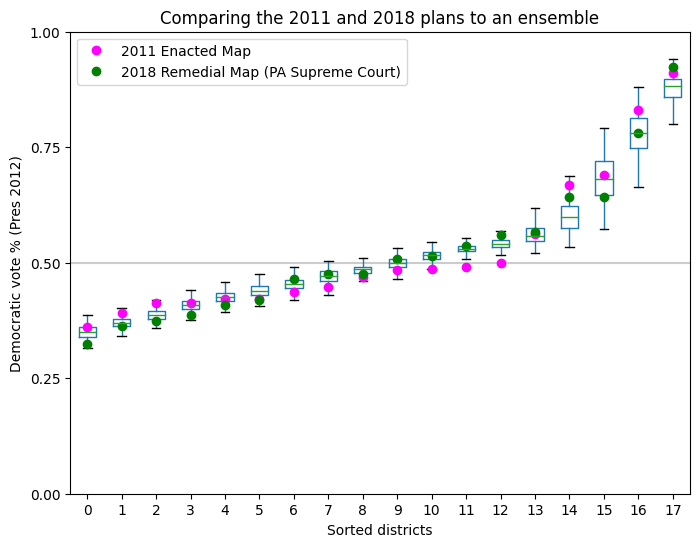

In [22]:
# Plot of histograms of districts in ensemble ranked according to % of democratic vote
# Compare with actual enacted maps: 2011 and 2018 ***** K

fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, showfliers=False, positions=range(0,len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
data_enacted2011.iloc[0].plot(style="o", color="magenta", ax=ax, label="2011 Enacted Map")
data_remedial.iloc[0].plot(style="o", color="green", ax=ax, label="2018 Remedial Map (PA Supreme Court)")

#initial_partition["PRES16"].percents("Second").plot(style="bo", ax=ax)

# Annotate
ax.set_title("Comparing the 2011 and 2018 plans to an ensemble")
ax.set_ylabel("Democratic vote % (Pres 2012)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

ax.legend()

plt.show()

In [23]:
# Histogram showing what the count of districts for each party was vs the one for the map enacted.

d_wins_counters = []
d_wins_interpolated = []

for i in range(len(data)):
    v = data.iloc[i]
    d_dists = 0
    pointer = len(v) - 1
    while pointer >= 0 and v[pointer] >= 0.5:
        d_dists += 1
        pointer -= 1
    d_wins_counters.append(d_dists)
    
    smallest_D_win = v[pointer+1]
    smallest_R_win = 1 - v[pointer]
    
    # print(smallest_D_win, smallest_R_win)
    
    interpolated = (.5 - (1 - smallest_D_win )) / (smallest_R_win - (1 - smallest_D_win))
    # print(interpolated)
    
    d__dists_interpolated = d_dists + interpolated
    d_wins_interpolated.append(d__dists_interpolated)

In [24]:
# print(d_wins_counters)
# print(d_wins_interpolated)

print(sorted(d_wins_interpolated))


[6.800866065869598, 6.800866065869598, 6.800866065869598, 6.826405932103908, 6.861965294004614, 6.861965294004614, 6.861965294004614, 6.87768010767765, 6.87768010767765, 6.87768010767765, 6.902991000539202, 6.902991000539202, 6.902991000539202, 6.949889012951537, 6.973793359260544, 7.194550385449802, 7.194550385449802, 7.435763648552762, 7.498059980866263, 7.498059980866263, 7.498059980866263, 7.498059980866263, 7.498059980866263, 7.498059980866263, 7.50075407434324, 7.50075407434324, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.508938946044487, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.512800718781505, 7.513711386933583, 7.51764824492145

In [25]:
# Calculate interpolation score for 2011 enacted map:
d_wins_counters_enacted2011 = []
d_wins_interpolated_enacted2011 = []

for i in range(len(data_enacted2011)):
    v = data_enacted2011.iloc[i]
    d_dists = 0
    pointer = len(v) - 1
    while pointer >= 0 and v[pointer] >= 0.5:
        d_dists += 1
        pointer -= 1
    d_wins_counters_enacted2011.append(d_dists)
    
    smallest_D_win = v[pointer+1]
    smallest_R_win = 1 - v[pointer]
    
    # print(smallest_D_win, smallest_R_win)
    
    interpolated = (.5 - (1 - smallest_D_win )) / (smallest_R_win - (1 - smallest_D_win))
    # print(interpolated)
    
    d__dists_interpolated = d_dists + interpolated
    d_wins_interpolated_enacted2011.append(d__dists_interpolated)

In [26]:
print("Interpolated score for enacted 2011:", d_wins_interpolated_enacted2011[0])

Interpolated score for enacted 2011: 5.994241658742689


In [27]:
# Calculate interpolation score for remedial map:
d_wins_counters_remedial = []
d_wins_interpolated_remedial = []

for i in range(len(data_remedial)):
    v = data_remedial.iloc[i]
    d_dists = 0
    pointer = len(v) - 1
    while pointer >= 0 and v[pointer] >= 0.5:
        d_dists += 1
        pointer -= 1
    d_wins_counters_remedial.append(d_dists)
    
    smallest_D_win = v[pointer+1]
    smallest_R_win = 1 - v[pointer]
    
    # print(smallest_D_win, smallest_R_win)
    
    interpolated = (.5 - (1 - smallest_D_win )) / (smallest_R_win - (1 - smallest_D_win))
    # print(interpolated)
    
    d__dists_interpolated = d_dists + interpolated
    d_wins_interpolated_remedial.append(d__dists_interpolated)

In [28]:
print("Interpolated score for remedial 2018:", d_wins_interpolated_remedial[0])

Interpolated score for remedial 2018: 9.256599686913166


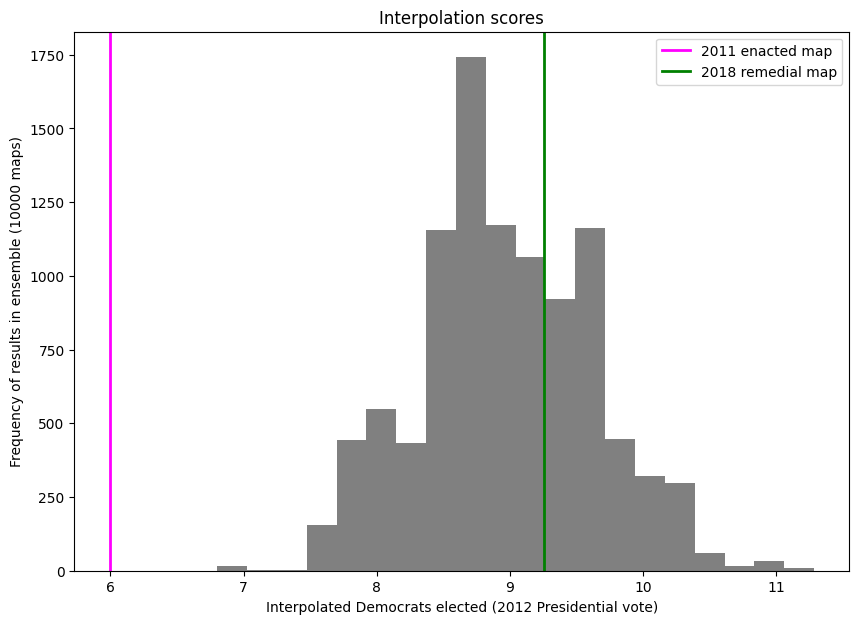

In [29]:
## Interpolation plot ***** Nico
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(d_wins_interpolated, bins = 20, color="gray")

# reference for the box and whiskers plot

ax.set_title("Interpolation scores")
ax.set_ylabel("Frequency of results in ensemble (10000 maps)")
ax.set_xlabel("Interpolated Democrats elected (2012 Presidential vote)")
plt.axvline(x = d_wins_interpolated_enacted2011[0], color = 'magenta', lw = 2, label = '2011 enacted map')
plt.axvline(x = d_wins_interpolated_remedial[0], color = 'green', lw = 2, label = '2018 remedial map') 

# Show plot
plt.legend()

plt.show()

In [30]:
# Plots of frequency for representative index and calculation of 2011's representative score
# Exact representatitve score ***** Nico


mean_d_wins_interpol = sum(d_wins_interpolated) / len(d_wins_interpolated)
print("Mean of the histogram of interpolated values:", mean_d_wins_interpol)


enacted2011_interpolated = d_wins_interpolated_enacted2011[0] # This is for enacted
remedial_interpolated = d_wins_interpolated_remedial[0]


distances_from_mean_d_wins = []

for result in d_wins_interpolated:
    distances_from_mean_d_wins.append(abs(result - mean_d_wins_interpol))


# print(distances_from_mean_d_wins)
enacted2011_rscore = abs(mean_d_wins_interpol - enacted2011_interpolated)
remedial_rscore = abs(mean_d_wins_interpol - remedial_interpolated)
print("Enacted 2011 Representativeness score: ", enacted2011_rscore)
print("Remedial 2018 Representativeness score: ", remedial_rscore)

count_worse_than_2011 = 0
for rscore in distances_from_mean_d_wins:
    # print(rscore)
    if rscore > enacted2011_rscore:
        count_worse_than_2011 = count_worse_than_2011 + 1
        
print(count_worse_than_2011)

print("Proportion of maps in ensemble with worse R-score than 2011:", count_worse_than_2011*1.0 / len(distances_from_mean_d_wins)*1.0)

Mean of the histogram of interpolated values: 8.967282117008855
Enacted 2011 Representativeness score:  2.9730404582661656
Remedial 2018 Representativeness score:  0.2893175699043109
0
Proportion of maps in ensemble with worse R-score than 2011: 0.0


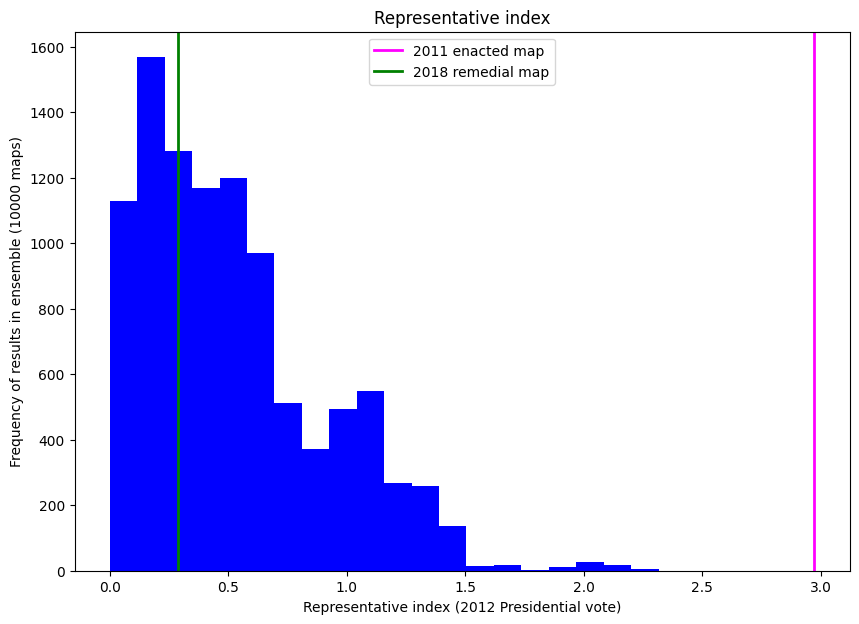

In [32]:
# Histogram for representative index ***** Nico

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(distances_from_mean_d_wins, bins = 20, color="blue")

ax.set_title("Representative index")
ax.set_ylabel("Frequency of results in ensemble (10000 maps)")
ax.set_xlabel("Representative index (2012 Presidential vote)")
plt.axvline(x = enacted2011_rscore, color = 'magenta', lw = 2, label = '2011 enacted map')
plt.axvline(x = remedial_rscore, color = 'green', lw = 2, label = '2018 remedial map') 
plt.legend()

# Show plot
plt.show()

In [37]:
# Based on these results, the 2011 map appears to be a significant outlier. 
# Note: only 10000 iterations of chain.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=01722cce-db8d-4a90-9749-af129fe2802b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>